# S2-regrid-export-workflow

**Date:** <br>
23 November 2021 <br>
**Background:** <br>
Issue -  <br>
**Author(s):**<br>
Thomas Moore<br>

### OOD documentation
https://opus.nci.org.au/display/DAE/Setting+up+a+Dask+Cluster+on+OOD

In [1]:
Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

In [2]:
import xarray as xr
import numpy as np
import xrft
import xesmf as xe
import scipy
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os
import re
import cartopy.crs as ccrs
import proplot as pplt
%config Completer.use_jedi = False

/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/proplot/__init__.py:71: ProplotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


In [ ]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

## OOD cluster

In [3]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,processes=1,memory="47GB",walltime='01:00:00')
client = Client(cluster)
cluster.scale(cores=24)

/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [4]:
print(client)

<Client: 'tcp://10.0.128.160:37135' processes=0 threads=0, memory=0 B>


In [7]:
client

<Client: 'tcp://10.0.128.160:37135' processes=8 threads=8, memory=350.16 GiB>

In [6]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=44G
#SBATCH -t 01:00:00

/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/bin/python -m distributed.cli.dask_worker tcp://10.0.128.160:37135 --nthreads 1 --memory-limit 43.77GiB --name dummy-name --nanny --death-timeout 60 --protocol tcp://



# Turn ON/OFF debugging

In [7]:
# define preprocess drop function - this unfortunately removes useful information like areau that's missing from 2015 files
def drop_not_in_2015(ds):
    if 'latu_bounds' in ds.data_vars:
        ds = ds.drop(['latu_bounds'])
    if 'lonu_bounds' in ds.data_vars:
        ds = ds.drop(['lonu_bounds'])
    if 'latv_bounds' in ds.data_vars:
        ds = ds.drop(['latv_bounds'])
    if 'lonv_bounds' in ds.data_vars:
        ds = ds.drop(['lonv_bounds'])
    if 'latt_bounds' in ds.data_vars:
        ds = ds.drop(['latt_bounds'])
    if 'lont_bounds' in ds.data_vars:
        ds = ds.drop(['lont_bounds'])    
    if 'depthu_bounds' in ds.data_vars:
        ds = ds.drop(['depthu_bounds'])
    if 'areau' in ds.data_vars:
        ds = ds.drop(['areau'])
    if 'depthv_bounds' in ds.data_vars:
        ds = ds.drop(['depthv_bounds'])
    if 'areav' in ds.data_vars:
        ds = ds.drop(['areav'])
    if 'deptht_bounds' in ds.data_vars:
        ds = ds.drop(['deptht_bounds'])
    if 'areat' in ds.data_vars:
        ds = ds.drop(['areat'])        
    return ds

# SST, SSS, MLD1-2,d20,HC300,td

### load the whole timeseries using `drop` preproccessor

In [ ]:
%%time
ds_SST_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/sst/mo_sst_*.nc',parallel=True,preprocess=drop_not_in_2015)
#ds_SST_1981_2018 = xr.open_mfdataset(
#    [f'/g/data/ux62/access-s2/reanalysis/ocean/sst/mo_sst_{x}.nc' for x in range(year_start, year_end)],parallel=True,preprocess=drop_not_in_2015
#)

In [ ]:
%%time
ds_SSS_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/sss/mo_sss_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_mld1_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/mld1/mo_mld1_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_mld2_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/mld2/mo_mld2_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_D20_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/d20/mo_d20_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_hc300_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/hc300/mo_hc300_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_td_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_temp_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/temp/mo_temp_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
ds_temp50_1981_2018 = ds_temp_1981_2018.sel(deptht=50,method='nearest').rename({'temp':'temp50'})
ds_temp100_1981_2018 = ds_temp_1981_2018.sel(deptht=100,method='nearest').rename({'temp':'temp100'})
ds_temp200_1981_2018 = ds_temp_1981_2018.sel(deptht=200,method='nearest').rename({'temp':'temp200'})
ds_temp500_1981_2018 = ds_temp_1981_2018.sel(deptht=500,method='nearest').rename({'temp':'temp500'})

In [ ]:
ds_ACCESS_S2_RA_ocean = xr.merge([ds_temp50_1981_2018.drop('deptht'),
                                  ds_temp100_1981_2018.drop('deptht'),
                                  ds_temp200_1981_2018.drop('deptht'),
                                  ds_temp500_1981_2018.drop('deptht'),
                                  ds_SST_1981_2018.squeeze(),
                                  ds_SSS_1981_2018.squeeze(),
                                  ds_mld1_1981_2018,
                                  ds_mld2_1981_2018,
                                  ds_D20_1981_2018,
                                  ds_hc300_1981_2018,
                                  ds_td_1981_2018
                                 ],compat='override')
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.drop('time_counter_bnds')
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.drop('deptht')
ds_ACCESS_S2_RA_ocean

## add back in key metadata

In [ ]:
areat = (xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/sst/mo_sst_2016.nc',parallel=True)).areat.to_dataset()
areau = (xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/u/mo_u_2016.nc',parallel=True)).areau.to_dataset()
areav = (xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/v/mo_v_2016.nc',parallel=True)).areav.to_dataset()

In [ ]:
ds_ACCESS_S2_RA_ocean = xr.combine_by_coords([ds_ACCESS_S2_RA_ocean,areat])
ds_ACCESS_S2_RA_ocean

# Deal with the same depth coordinates given two different names & rename time

In [ ]:
#ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.rename({'deptht':'depth','time_counter':'time'})
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.rename({'time_counter':'time'})

In [ ]:
ds_ACCESS_S2_RA_ocean.sst.isel(time=0).plot(size = 10)

In [ ]:
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
ds_ACCESS_S2_RA_ocean

In [ ]:
ds_ACCESS_S2_RA_ocean.nbytes/1e9

# SAVE ocean tgrid zarr file

In [ ]:
%%time
ds_ACCESS_S2_RA_ocean.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.nativeTgrid.zarr',consolidated=True)

# Check if zarr collections exist in `/g/data/v14/tm4888/data/ACCESS-S2/` and skip above
# $\Downarrow$

In [12]:
ds_ACCESS_S2_RA_ocean_nativeTgrid = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.nativeTgrid.zarr',consolidated=True)

CPU times: user 774 ms, sys: 83.8 ms, total: 858 ms
Wall time: 2.45 s


Text(0.5, 1.0, 'mld1')

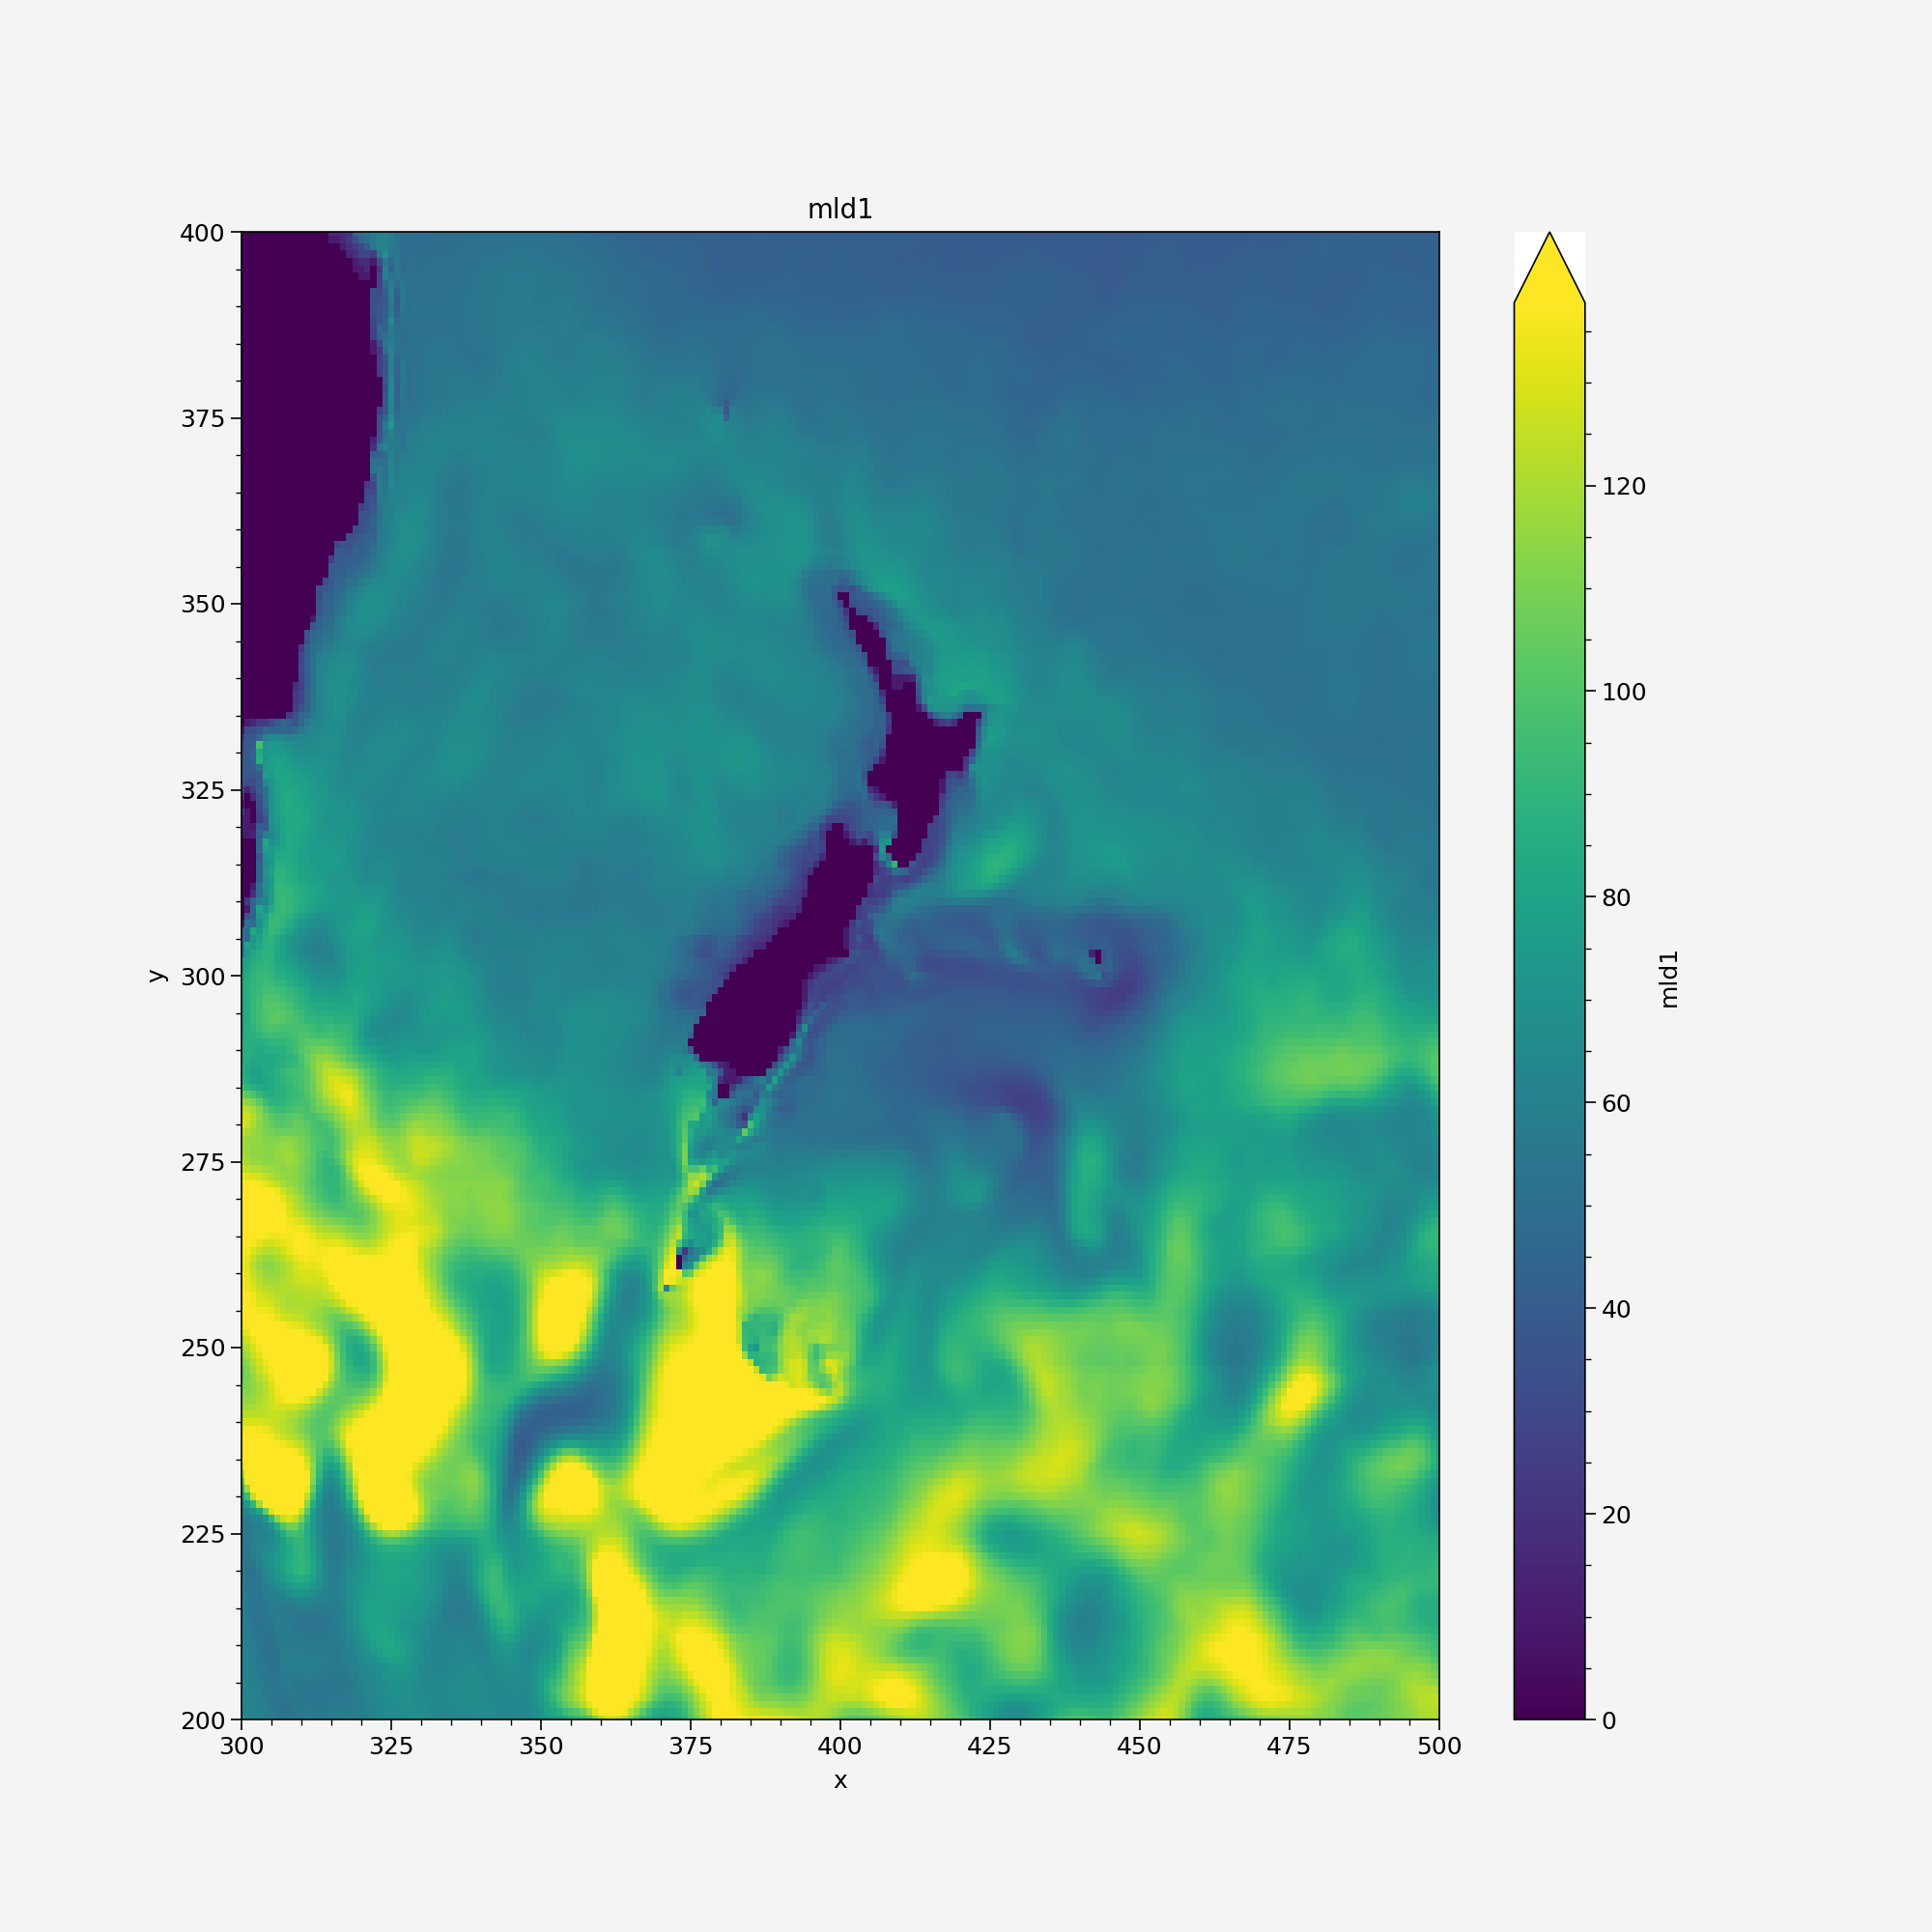

In [13]:
%%time
ds_ACCESS_S2_RA_ocean_nativeTgrid.mld1.mean('time').plot(robust=True)
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.ylim([200, 400])
plt.xlim([300, 500])
plt.xlabel('x')
plt.ylabel('y')
plt.title('mld1')

# memory // 16GB plus 160GB on cluster

In [14]:
ds_ACCESS_S2_RA_ocean_nativeTgrid.nbytes/1e9

31.112267064

#### let's not persist this given crash on write
ds_ACCESS_S2_RA_ocean_nativeTgrid = ds_ACCESS_S2_RA_ocean_nativeTgrid.persist()

# Regridding Step

## curvilinear grid

In [15]:
nav_lon = ds_ACCESS_S2_RA_ocean_nativeTgrid['lon'].compute()
nav_lat = ds_ACCESS_S2_RA_ocean_nativeTgrid['lat'].compute()

Text(0.5, 1.0, 'ACCESS-S2 Curvilinear grid')

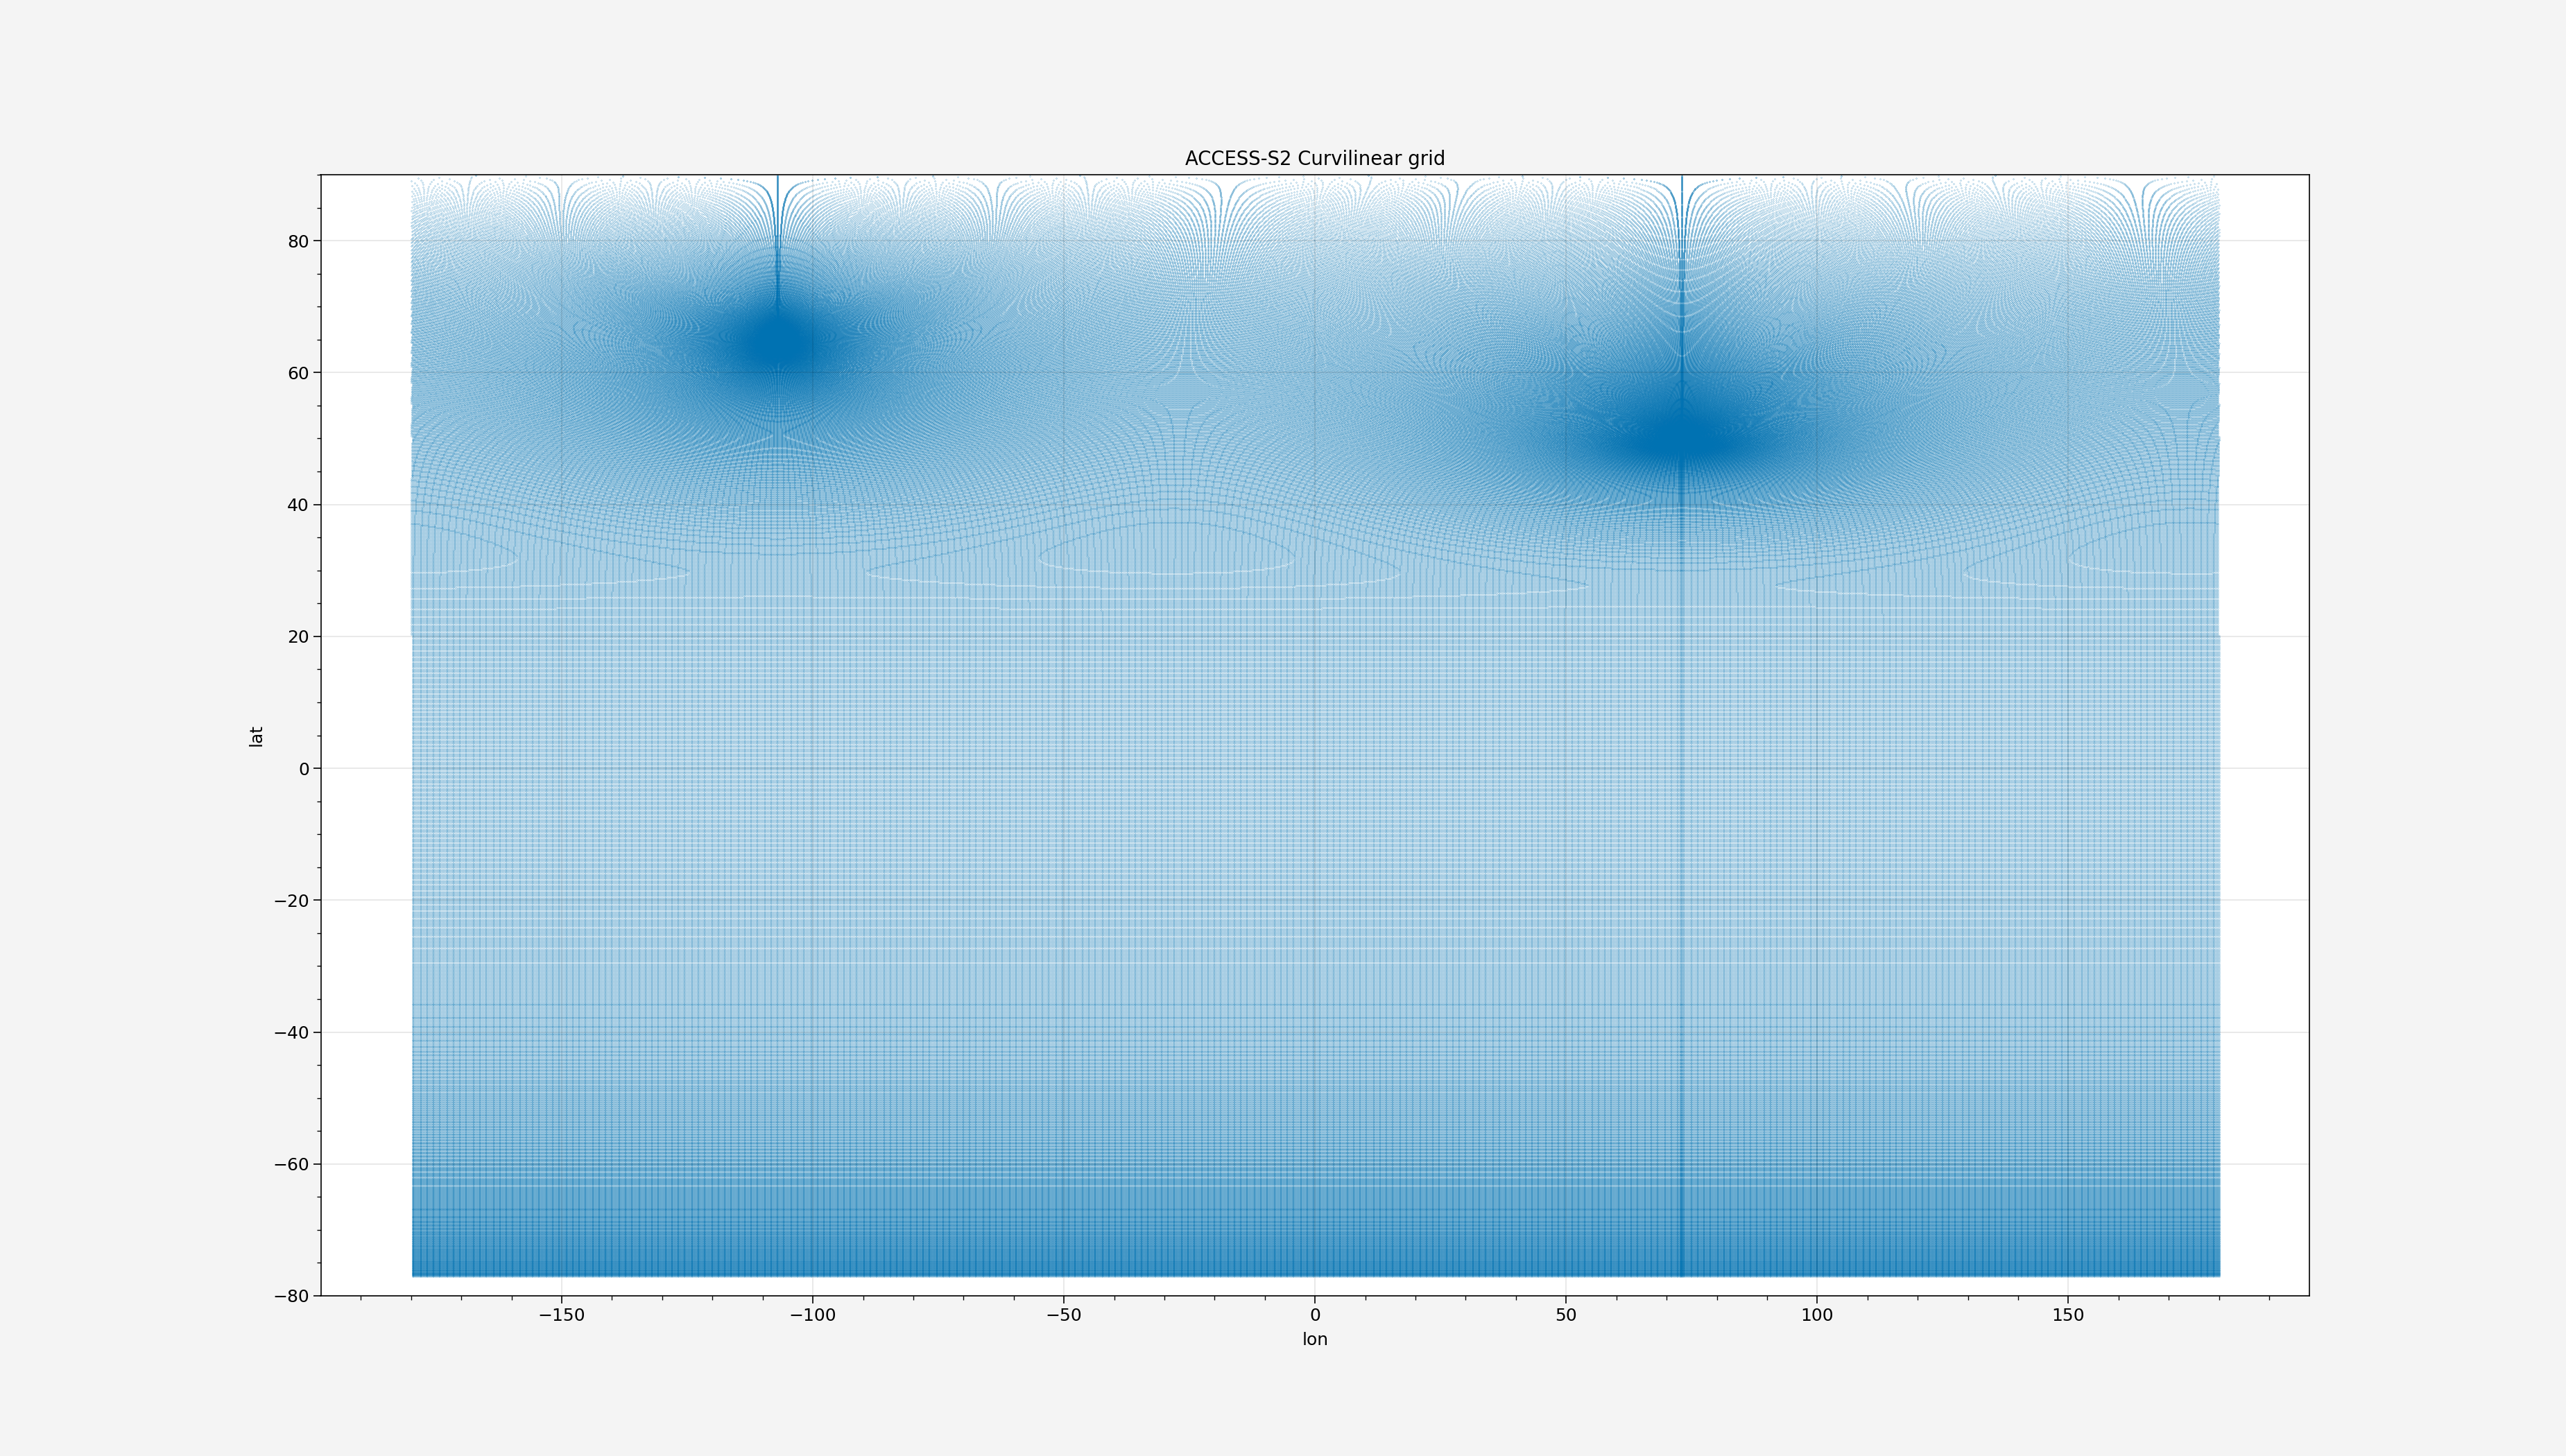

In [16]:
plt.scatter(nav_lon, nav_lat, s=0.01)  # plot grid locations
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.ylim([-80, 90])
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('ACCESS-S2 Curvilinear grid')

# CHOOSE YOUR NEW GRID // define uniform 1x1 grid

In [17]:
new_1deg_grid = xe.util.grid_global(1, 1)
new_1deg_grid

<xarray.Dataset>
Dimensions:  (y: 180, x: 360, y_b: 181, x_b: 361)
Coordinates:
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon_b    (y_b, x_b) int64 -180 -179 -178 -177 -176 ... 176 177 178 179 180
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 ... 90 90 90 90 90 90
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

Text(0.5, 1.0, 'uniform grid')

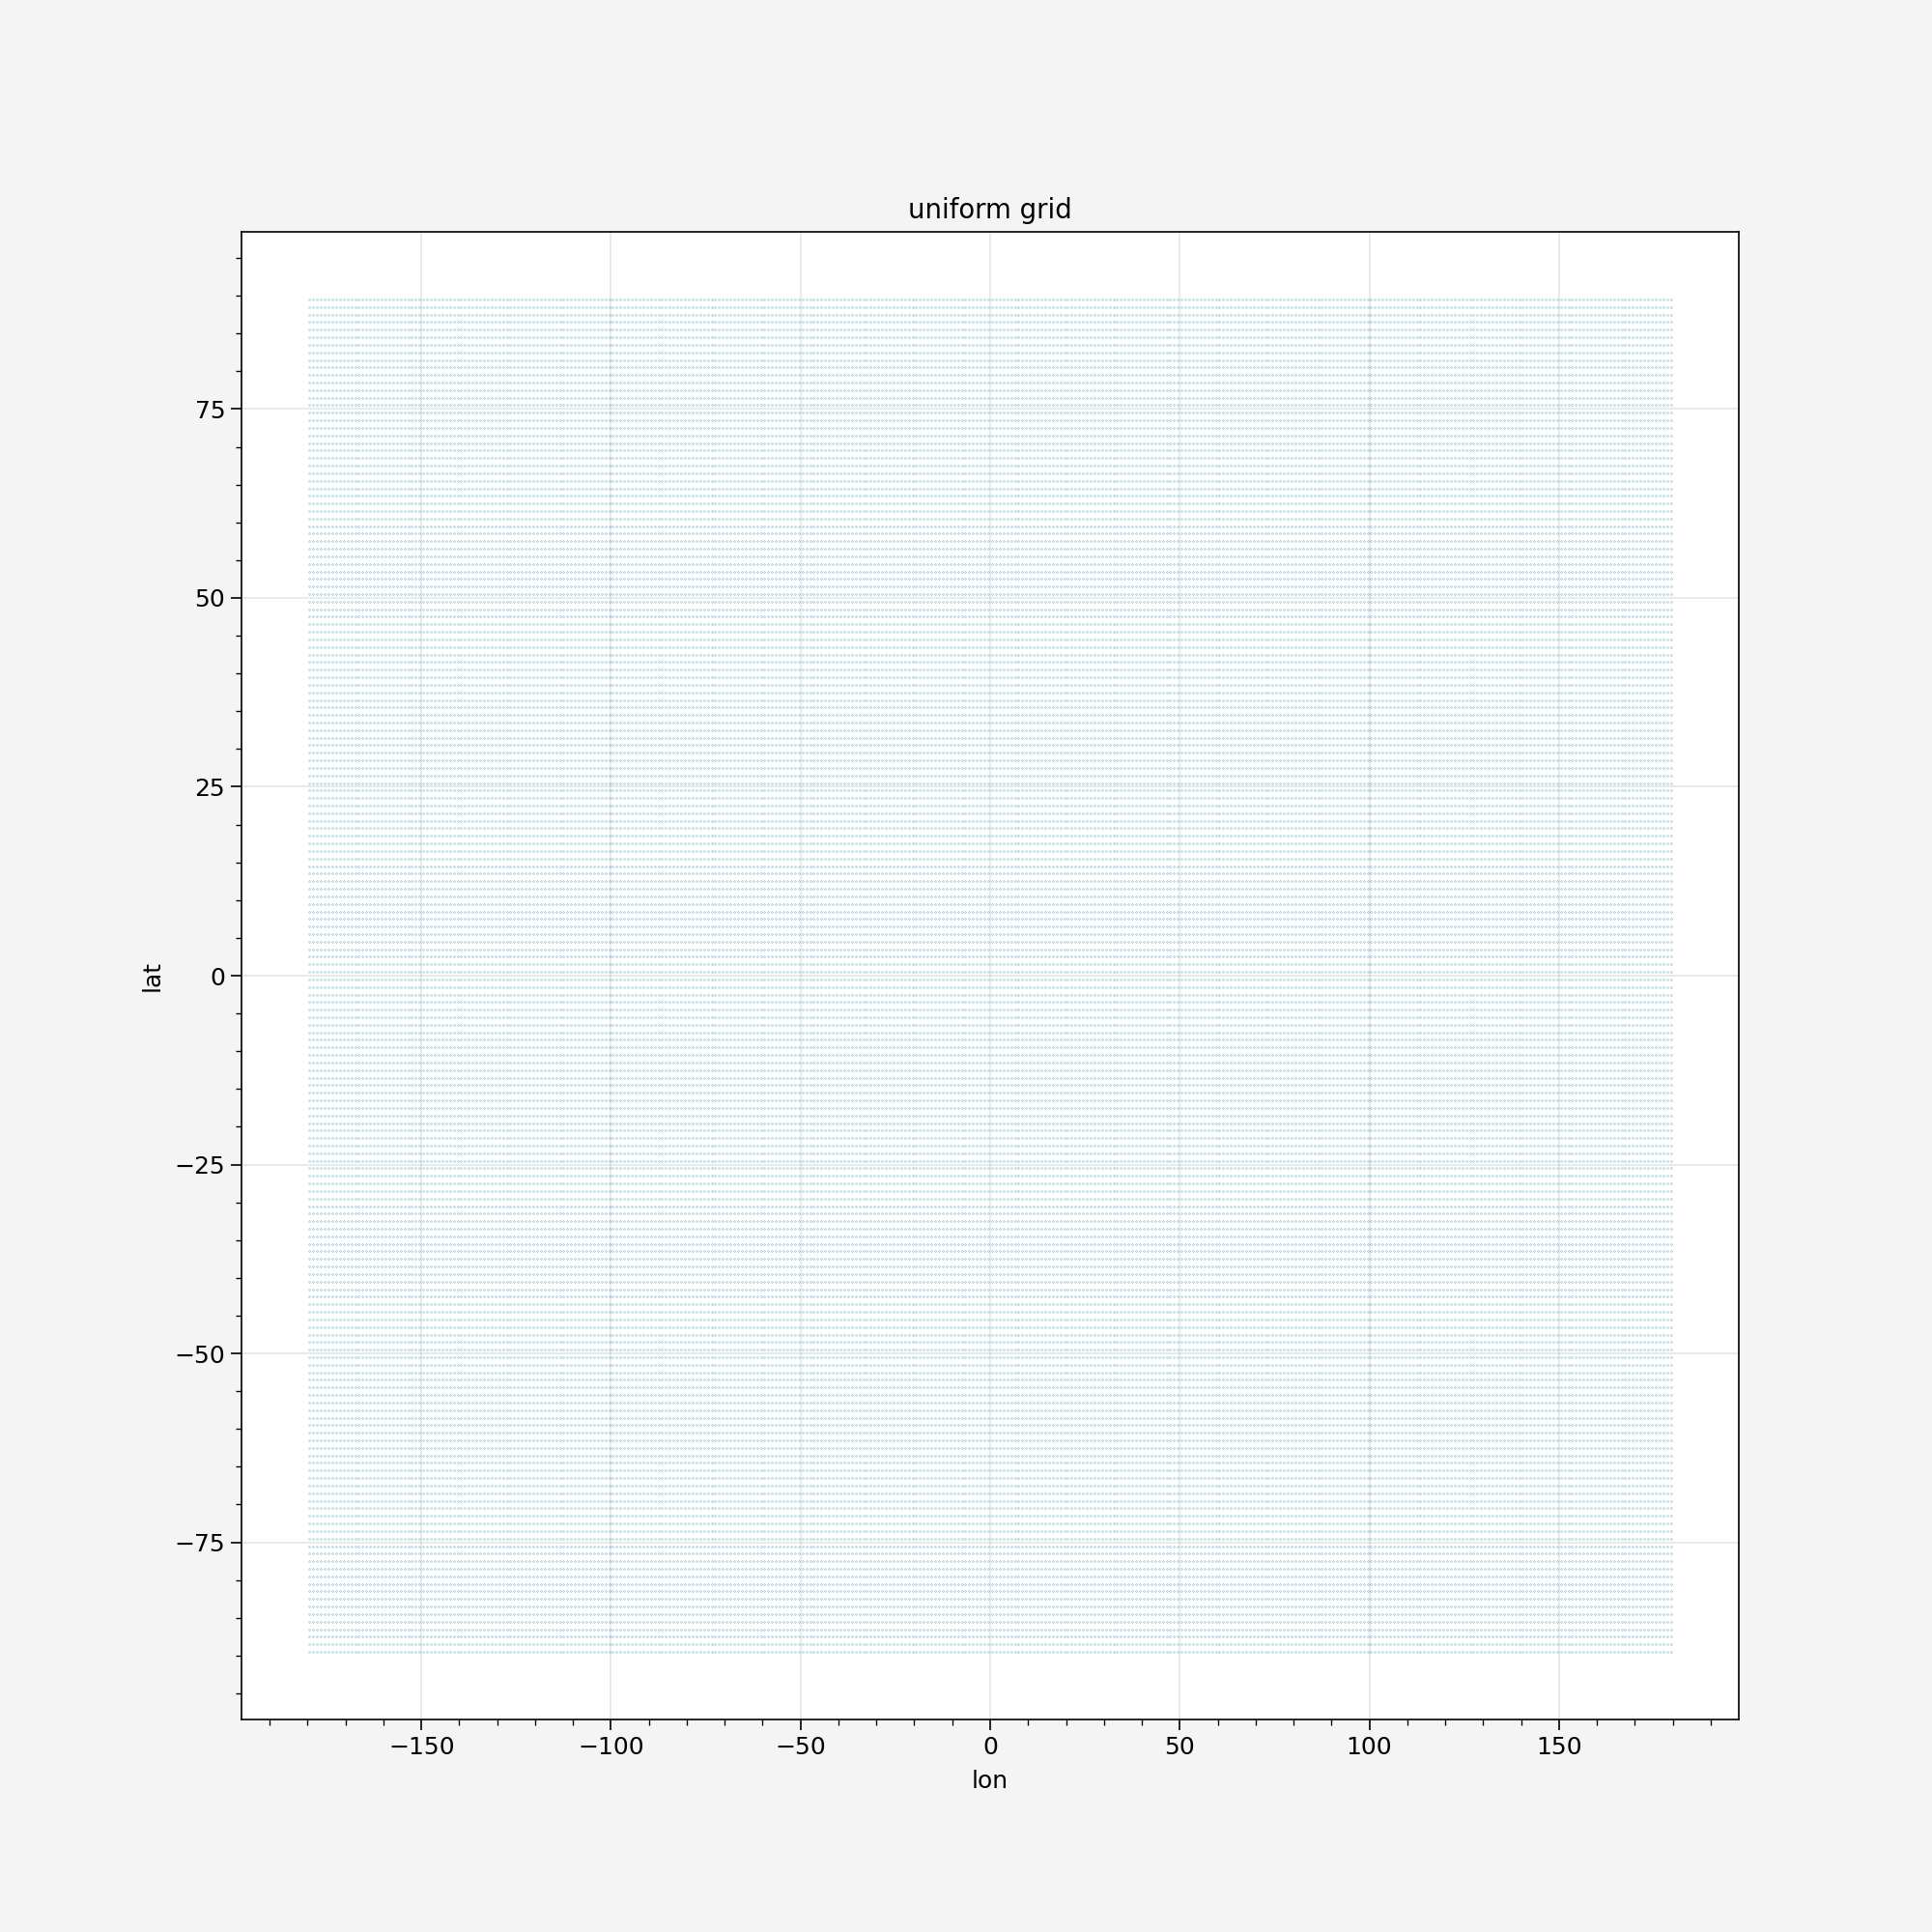

In [18]:
plt.scatter(new_1deg_grid.lon, new_1deg_grid.lat, s=0.01)  # plot grid locations
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('uniform grid')

In [19]:
%%time
regridder_S2_1deg_Tgrid = xe.Regridder(ds_ACCESS_S2_RA_ocean_nativeTgrid, new_1deg_grid,'bilinear', ignore_degenerate=True, periodic=True,reuse_weights=False)

CPU times: user 1min 3s, sys: 7.8 s, total: 1min 11s
Wall time: 1min 8s


## EARTH SYSTEM MODELLING FRAMEWORK (NCAR / NOAA) - https://en.wikipedia.org/wiki/Earth_System_Modeling_Framework </br></br>  xESMF // https://github.com/JiaweiZhuang/xESMF/blob/master/README.rst

## $\bigstar$ solution to parallel regridding issue = https://github.com/JiaweiZhuang/xESMF/issues/71

#### regrid the full dataset object

In [20]:
%%time
regridder_S2_1deg_Tgrid._grid_in = None
regridder_S2_1deg_Tgrid._grid_out = None
ds_ACCESS_S2_RA_ocean_1degRegrid = regridder_S2_1deg_Tgrid(ds_ACCESS_S2_RA_ocean_nativeTgrid)

CPU times: user 6.75 s, sys: 217 ms, total: 6.97 s
Wall time: 8.01 s


In [21]:
ds_ACCESS_S2_RA_ocean_1degRegrid

<xarray.Dataset>
Dimensions:  (y: 180, x: 360, time: 480)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2020-12-01T12:00:00
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
Dimensions without coordinates: y, x
Data variables:
    areat    (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    d20      (time, y, x) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    hc300    (time, y, x) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    mld1     (time, y, x) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    mld2     (time, y, x) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    sss      (time, y, x) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    sst      (time, y, x) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    td       (time, y, x) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp100  (time, y, x) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp200  (time, y, x) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp50   (time, y, x) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp500  (time, y, x) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [22]:
ds_ACCESS_S2_RA_ocean_1degRegrid = ds_ACCESS_S2_RA_ocean_1degRegrid.assign_coords({'x': ds_ACCESS_S2_RA_ocean_1degRegrid.lon.isel(y=0),'y': ds_ACCESS_S2_RA_ocean_1degRegrid.lat.isel(x=0)}).drop(['lon','lat']).rename({'x':'lon','y':'lat'})

In [23]:
ds_ACCESS_S2_RA_ocean_1degRegrid

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 480)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2020-12-01T12:00:00
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    areat    (lat, lon) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    d20      (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    hc300    (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    mld1     (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    mld2     (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    sss      (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    sst      (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    td       (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp100  (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp200  (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp50   (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp500  (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [24]:
ds_ACCESS_S2_RA_ocean_1degRegrid.nbytes/1e9

1.36884336

## Sanity check

In [25]:
%%time
regrid_data = ds_ACCESS_S2_RA_ocean_1degRegrid.mld1.mean(dim='time').compute()
coarsened_data = ds_ACCESS_S2_RA_ocean_nativeTgrid.mld1.mean(dim='time')
coarsened_data = coarsened_data.coarsen({'x':4,'y':4}, boundary="trim").mean().compute()

CPU times: user 1.74 s, sys: 396 ms, total: 2.13 s
Wall time: 10.4 s


CPU times: user 218 ms, sys: 17.5 ms, total: 235 ms
Wall time: 227 ms


(36.0, 107.0)

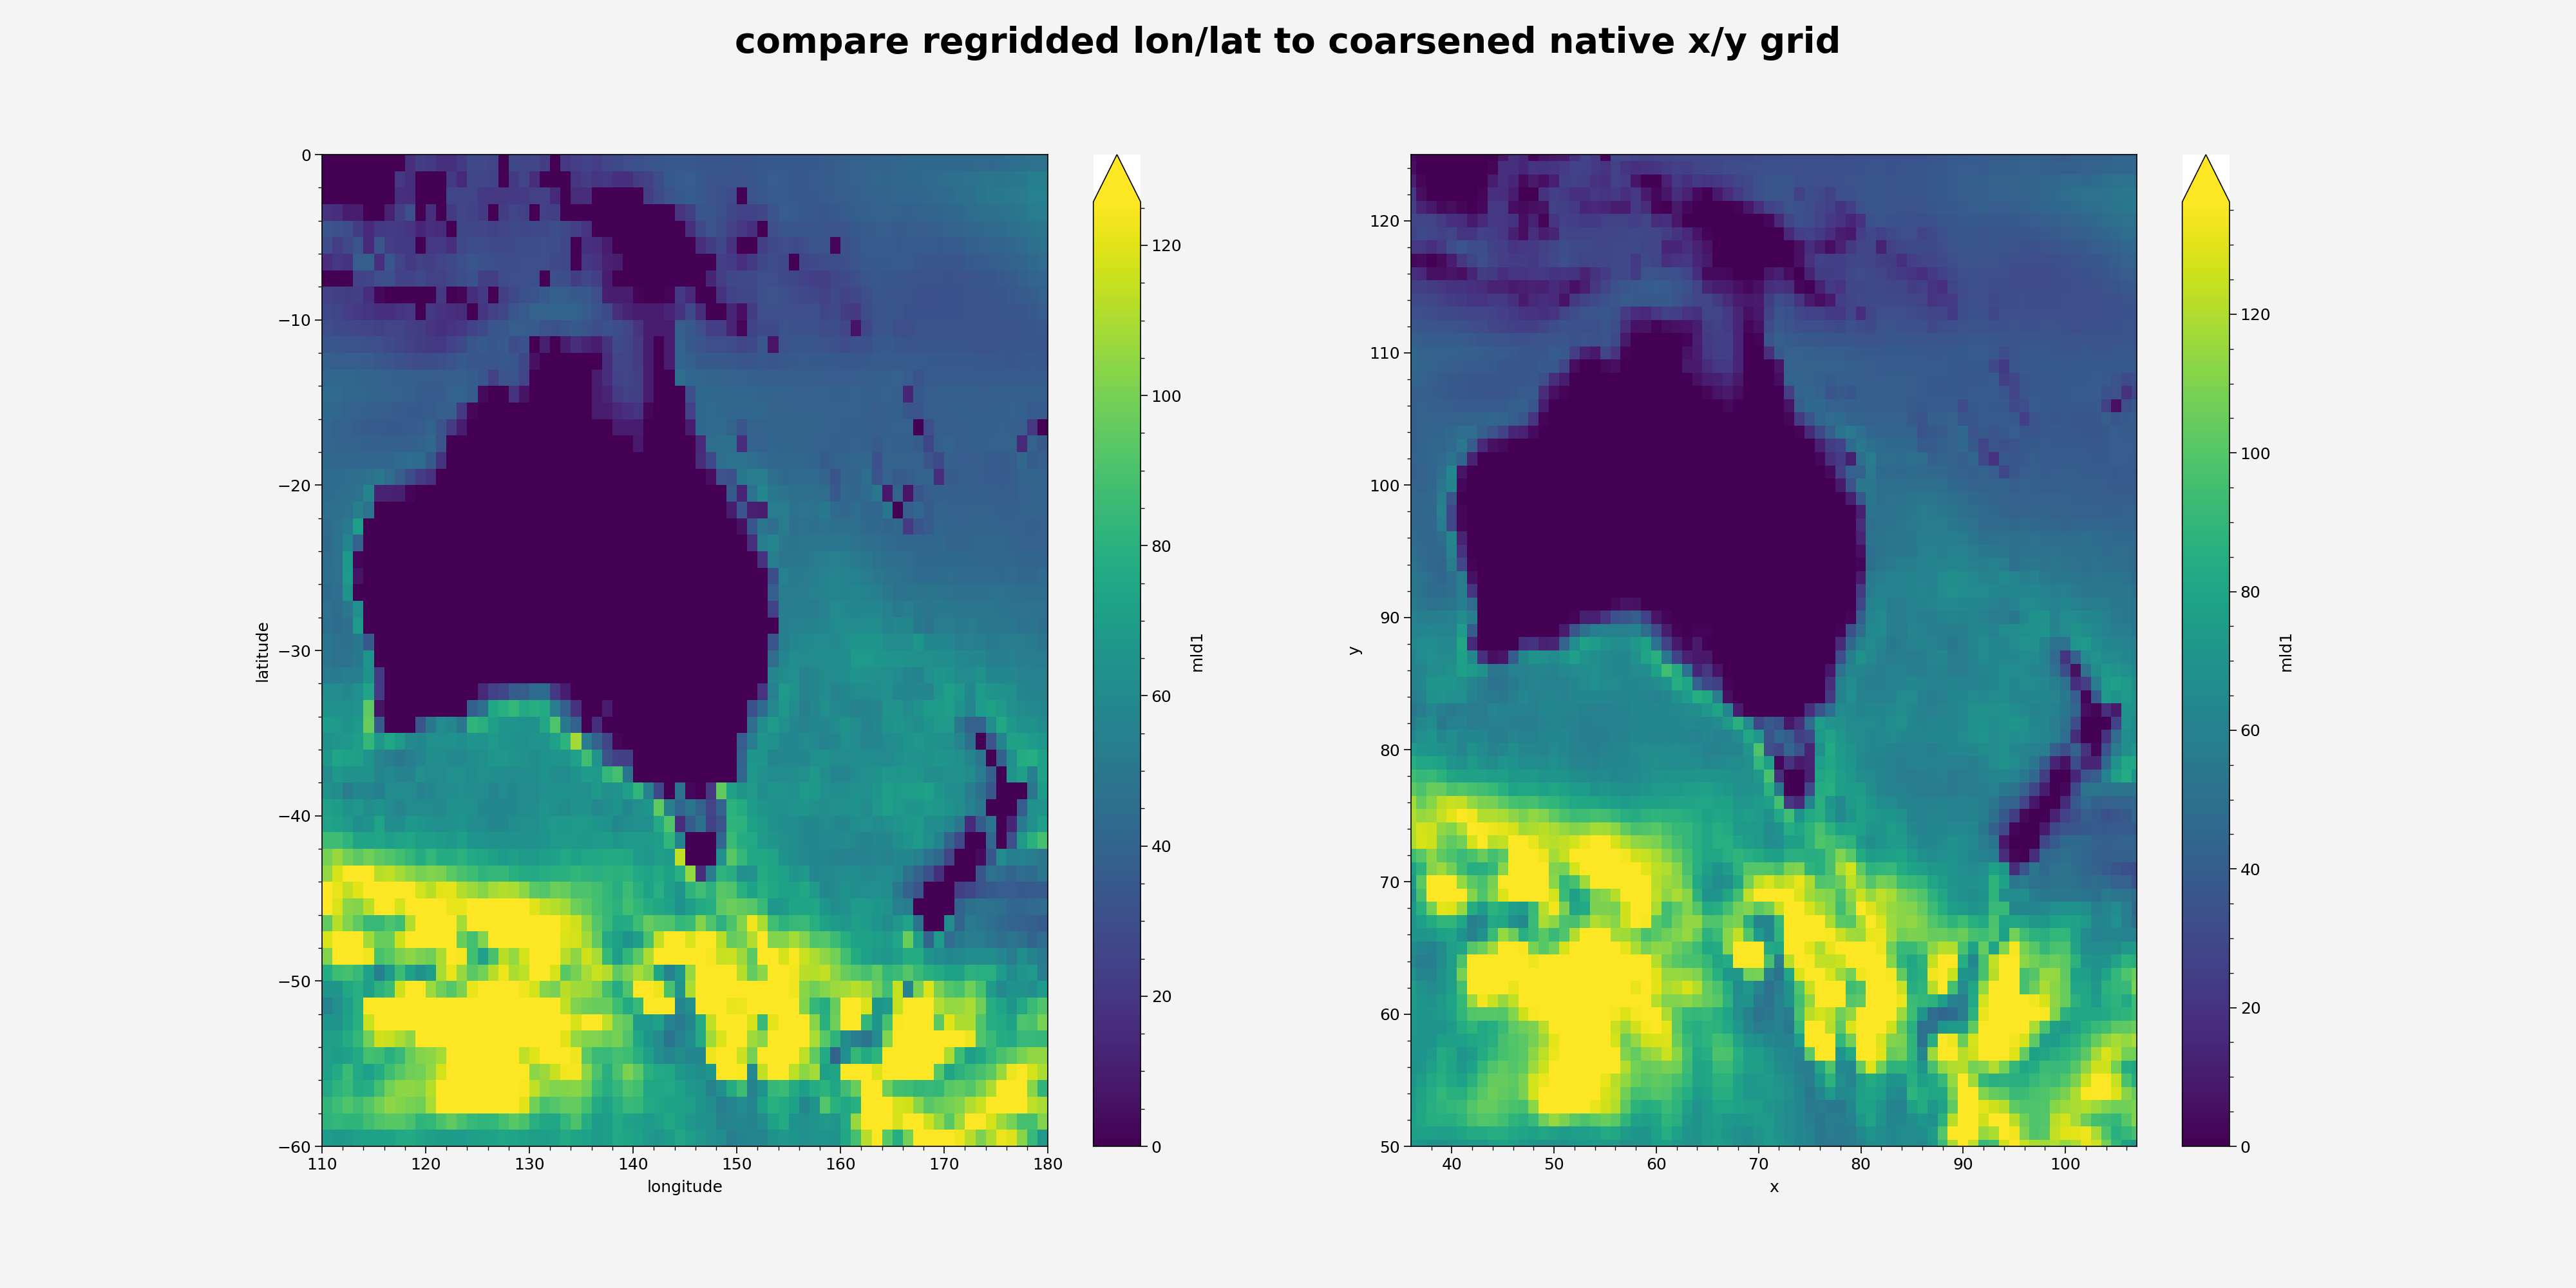

In [26]:
%%time
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
fig.suptitle('compare regridded lon/lat to coarsened native x/y grid',fontsize=20)
regrid_data.plot(robust=True,ax=ax1)
coarsened_data.plot(robust=True,ax=ax2)
ax1.set_ylim([-60,0])
ax1.set_xlim([110,180])
ax2.set_ylim([50,125])
ax2.set_xlim([36,107])

# write 1deg Tgrid file to zarr

In [27]:
ds_ACCESS_S2_RA_ocean_1degRegrid

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 480)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2020-12-01T12:00:00
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    areat    (lat, lon) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    d20      (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    hc300    (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    mld1     (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    mld2     (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    sss      (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    sst      (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    td       (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp100  (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp200  (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp50   (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp500  (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [28]:
%%time
ds_ACCESS_S2_RA_ocean_1degRegrid.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.Tregrid_1deg.zarr',consolidated=True)

CPU times: user 7.52 s, sys: 860 ms, total: 8.38 s
Wall time: 31.6 s


# U & V

# Check if zarr collections exist in `/g/data/v14/tm4888/data/ACCESS-S2/` and skip arrows if you can
# $\Downarrow$

# ACCESS-S2 ocean reanalysis (RA) 1981 - 2018

# load U & V S2_RA

In [22]:
%%time
# define preprocess drop function - this unfortunately removes useful information like areau that's missing from 2015 files
def drop_not_in_2015(ds):
    if 'latu_bounds' in ds.data_vars:
        ds = ds.drop(['latu_bounds'])
    if 'lonu_bounds' in ds.data_vars:
        ds = ds.drop(['lonu_bounds'])
    if 'latv_bounds' in ds.data_vars:
        ds = ds.drop(['latv_bounds'])
    if 'lonv_bounds' in ds.data_vars:
        ds = ds.drop(['lonv_bounds'])
    if 'depthu_bounds' in ds.data_vars:
        ds = ds.drop(['depthu_bounds'])
    if 'areau' in ds.data_vars:
        ds = ds.drop(['areau'])
    if 'depthv_bounds' in ds.data_vars:
        ds = ds.drop(['depthv_bounds'])
    if 'areav' in ds.data_vars:
        ds = ds.drop(['areav'])    
    return ds
ds_u_1981_2020 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/u/mo_u_*.nc',parallel=True,preprocess=drop_not_in_2015)
ds_u_1981_2020

CPU times: user 4.52 s, sys: 968 ms, total: 5.49 s
Wall time: 11.8 s


<xarray.Dataset>
Dimensions:            (depthu: 75, y: 1021, x: 1442, time_counter: 480, tbnds: 2)
Coordinates:
  * depthu             (depthu) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter       (time_counter) datetime64[ns] 1981-01-16T12:00:00 ... ...
Dimensions without coordinates: y, x, tbnds
Data variables:
    time_counter_bnds  (time_counter, tbnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    u                  (time_counter, depthu, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:37:54 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:39:39 2019: ncatted -a history,global,d,, mo_...

In [23]:
%%time
# define preprocess drop function - this unfortunately removes useful information like areau that's missing from 2015 files
def drop_not_in_2015(ds):
    if 'latu_bounds' in ds.data_vars:
        ds = ds.drop(['latu_bounds'])
    if 'lonu_bounds' in ds.data_vars:
        ds = ds.drop(['lonu_bounds'])
    if 'latv_bounds' in ds.data_vars:
        ds = ds.drop(['latv_bounds'])
    if 'lonv_bounds' in ds.data_vars:
        ds = ds.drop(['lonv_bounds'])
    if 'depthu_bounds' in ds.data_vars:
        ds = ds.drop(['depthu_bounds'])
    if 'areau' in ds.data_vars:
        ds = ds.drop(['areau'])
    if 'depthv_bounds' in ds.data_vars:
        ds = ds.drop(['depthv_bounds'])
    if 'areav' in ds.data_vars:
        ds = ds.drop(['areav'])    
    return ds
ds_v_1981_2020 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/v/mo_v_*.nc',parallel=True,preprocess=drop_not_in_2015)
ds_v_1981_2020

CPU times: user 4.38 s, sys: 954 ms, total: 5.33 s
Wall time: 11.6 s


<xarray.Dataset>
Dimensions:            (depthv: 75, y: 1021, x: 1442, time_counter: 480, tbnds: 2)
Coordinates:
  * depthv             (depthv) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter       (time_counter) datetime64[ns] 1981-01-16T12:00:00 ... ...
Dimensions without coordinates: y, x, tbnds
Data variables:
    time_counter_bnds  (time_counter, tbnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    v                  (time_counter, depthv, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:37:34 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:08:10 2019: ncatted -a history,global,d,, mo_...

# Deal with the same depth coordinates given two different names & rename time

In [24]:
ds_u_1981_2020 = ds_u_1981_2020.rename({'depthu':'depth','time_counter':'time'})
ds_v_1981_2020 = ds_v_1981_2020.rename({'depthv':'depth','time_counter':'time'})

In [25]:
ds_v_1981_2020 

<xarray.Dataset>
Dimensions:            (depth: 75, y: 1021, x: 1442, time: 480, tbnds: 2)
Coordinates:
  * depth              (depth) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time               (time) datetime64[ns] 1981-01-16T12:00:00 ... 2020-12-...
Dimensions without coordinates: y, x, tbnds
Data variables:
    time_counter_bnds  (time, tbnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    v                  (time, depth, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:37:34 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:08:10 2019: ncatted -a history,global,d,, mo_...

# rechunk the data to shrink chunks from 5GB to 100MB
**could use `rechunker` here?**

In [ ]:
u = ds_u_1981_2020.chunk({'time':480,'depth':1,'x':250,'y':250})
v = ds_v_1981_2020.chunk({'time':480,'depth':1,'x':250,'y':250})

# write S2 nativue U & V to zarr collections

In [28]:
%%time
!rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.u.nativeUgrid.zarr
ds_u_1981_2020.to_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.u.nativeUgrid.zarr',consolidated=True)

ValueError: Codec does not support buffers of > 2147483647 bytes

In [29]:
%%time
!rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.v.nativeVgrid.zarr
ds_v_1981_2020.to_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.v.nativeVgrid.zarr',consolidated=True)

ContainsGroupError: path '' contains a group

# $\Downarrow$
# CAN SKIP TO THIS STEP IF U & V `ZARR` FILES ARE WRITTEN AND AVAILABLE
hard part for u & v done above

In [ ]:
u = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.u.zarr',consolidated=True)
v = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.v.zarr',consolidated=True)

# $ The\ End$

# Break glass in case of emergency
# $\Downarrow$

In [ ]:
client.restart()

In [ ]:
def calc_EKE(u, v, time_name = 'time'):
    '''
    Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}
    u,v are x and y currents as an xarray data array
    '''
    u_mean = u.mean(time_name)
    v_mean = v.mean(time_name)
    MKE = 0.5*(u_mean**2 + v_mean**2).rename('MKE') # currents
    EKE = ( 0.5 * ((u-u_mean)**2 + (v-v_mean)**2) ).rename('EKE') # eddies
    return EKE, MKE

In [ ]:
u_da = u.u
v_da = v.v

In [ ]:
%%time
[EKE, MKE] = calc_EKE(u_da, v_da, time_name='time')

In [ ]:
KE = xr.merge([EKE,MKE])

In [ ]:
KE

In [ ]:
%%time
!rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.zarr
KE.to_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.zarr',consolidated=True)

# $\Downarrow$
# CAN SKIP TO THIS STEP IF EKE `ZARR` FILE IS WRITTEN AND AVAILABLE
hard part for u & v & EKE & MKE done above

In [ ]:
KE = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.zarr',consolidated=True)

In [ ]:
EKE_mean = KE.EKE.mean('time').compute()

# reduce dataset to surface only

In [ ]:
KE_surface = KE.isel(depth=0).compute()

In [ ]:
KE_surface.sel(x=slice(250,450),y=slice(250,450)).mean('time').EKE.plot(vmax=.05)

# write file to netcdf

In [ ]:
%%time
KE_surface.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE_surface.nc',mode='w')

In [ ]:
KE = KE.persist()

In [ ]:
%%time
KE.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.nc',mode='w')

# $ The\ End$

# Break glass in case of emergency
# $\Downarrow$

In [5]:
client.restart()

<Client: 'tcp://10.0.128.141:42381' processes=2 threads=4, memory=87.54 GiB>

In [30]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [ ]:
client.restart()